# 第4章 ニューラルネットワークの学習

第3章で扱ったニューラルネットワークは、重み(${\bf W}$)とバイアス(${\bf b}$)を決めると、入力(${\bf x}$)から出力(${\bf y}$)が計算できます。この章で扱う学習は、多数のデータから${\bf W}$と${\bf b}$を計算する方法です。

# 4.1 データから学習する

データとして、多数の入力と出力の組みを持っていると仮定します。

$({\bf x}_1, {\bf t}_1), ({\bf x}_2, {\bf t}_2), ({\bf x}_3, {\bf t}_3), \cdots, ({\bf x}_N, {\bf t}_N)$

RTBの場合は、$i$番目のBidRequestに付随するデータを${\bf x}_i$とし、クリックしたかどうかを$t_i$とします。

手書きの数字認識の問題では、画像のpixelデータを${\bf x}_i$とし、0-9を表すデータを${\bf t}_i$とします。

入力${\bf x}_i$が与えられたときに、ニューラルネットワークを使えば予測値${\bf y}_i$が計算できます。

可能な限り${\bf y}_i$と${\bf t}_i$が近くなるようなニューラルネットワークが構築できれば、様々な入力に対して適切な出力を返すことができます。

# 4.2 損失関数

コンピュータを使って最良のパラメータの組み合わせを決定するためには、データをどれだけよく再現するかを表現する指標が必要です。

もっとも単純な指標は、教師データ${\bf t}_i$と予測値${\bf y}_i$の差を使って次のように定義される二乗和誤差です。

$$
    E = \frac{1}{2}\sum_k ({\bf y}_k-{\bf t}_k)^2
$$

教師データ${\bf t}_i$と予測値${\bf y}_i$が大きく異なると二乗和誤差は大きくなり、乖離が小さいと二乗和誤差は小さくなることがわかります。

二乗和誤差のように教師データ${\bf t}_i$と予測値${\bf y}_i$の違いを表現する関数を損失関数と呼びます。

別の損失関数として交差エントロピー誤差が使われます。

$$
    E = -\sum_k t_k \log y_k
$$


# 4.3 数値微分

損失関数をもっとも小さくするような重み(${\bf W}$)が計算することで最良のニューラルネットワークが計算できます。

実は関数を最小化する計算(最適化)は関数の傾きの計算、すなわち微分から決定できます。

# 4.3.1 微分

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

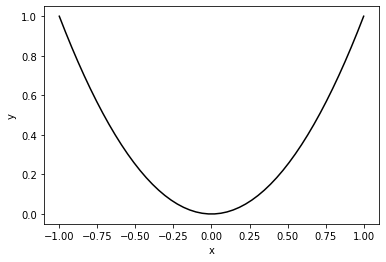

In [2]:
xs = np.linspace(-1, 1)
def plot_square():    
    ys = xs*xs
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(xs, ys, "k-", label="y=f(x)")
plot_square()

上の図は関数$f(x)=x^2$をプロットしたものです。この関数値(縦軸の値)をもっとも小さくなるような値(横軸の値)は何でしょうか？

答えは明確で$x=0$です。では、$x=0$の特徴は何でしょうか？

ひとつの特徴は、$x=0$において関数のグラフの**傾き**が$x$軸に対して水平になっていることです。

**傾き**をもう少し詳しく見ていきましょう。

直線の場合は**傾き**は明確です。直線を$y=ax$で表現すれば、$a$の値が傾きになります。

In [3]:
def f(a):
    xmin = -1
    xmax =  1
    
    xs = np.linspace(xmin, xmax)
    ys = a * xs
    plt.plot([xmin, xmax], [0, 0], "k--")
    plt.plot([0, 0], [xmin, xmax],  "k--")
    plt.plot(xs, ys, lw=2)
    plt.xlim(xmin, xmax)
    plt.ylim(-1, 1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

interact(f, a=(-3, 3, 0.5))

interactive(children=(FloatSlider(value=0.0, description='a', max=3.0, min=-3.0, step=0.5), Output()), _dom_cl…

<function __main__.f(a)>

では、曲線の傾きはどのように定義されるでしょうか。それは特定の点における接線の傾きとして定義されます。

関数$f(x)$の$x=x_0$における傾きを次のような記号を使って表現します。

$$
\frac{df}{dx}(x_0)
$$

In [4]:
def plot_slope(x0, label):
    ys = 2*x0*(xs - x0) + x0*x0
    plt.plot(xs, ys, label="slope at x={}".format(x0))

def f(x0):
    y0 = x0*x0
    plot_square()
    
    xmin = -1
    xmax =  1
    
    xs = np.linspace(xmin, xmax)
    ys = 2*x0*(xs - x0) + x0*x0
    plt.plot([xmin, xmax], [0, 0], "k--")
    plt.plot([0, 0], [xmin, xmax],  "k--")
    plt.plot(xs, ys, lw=2)
    plt.plot([x0], [y0], "bo")
    plt.xlim(xmin, xmax)
    plt.ylim(-1, 1)
    plt.xlabel("$x$")
    plt.ylabel("$y$")   
    print(r"df/dx = {}".format(2*x0))

interact(f, x0=(-1, 1, 0.25))    

interactive(children=(FloatSlider(value=0.0, description='x0', max=1.0, min=-1.0, step=0.25), Output()), _dom_…

<function __main__.f(x0)>

# 4.3.2 数値微分の例

上記の計算では二次関数の微分の性質を使って、傾き(=微分)を計算しましたが一般の関数では正確な微分を計算することは難しいです。

そこで、ここでは近似的な微分の計算手法である数値微分を導入します。

$$
\frac{df}{dx}(x_0) \approx \frac{f(x0+h)-f(x0)}{h}
$$

In [5]:
def numerical_diff(f):
    h = 1e-4
    def __func__(x0):    
        return (f(x0+h) - f(x0)) / h
    return __func__

def square(x):
    return x*x

x0 = 1.0
print("x0={}".format(square(x0)))
print("df/dx={}".format(2*x0))
print("numerical diff = {}".format(numerical_diff(square)(x0)))

x0=1.0
df/dx=2.0
numerical diff = 2.000099999999172


小さい$h$を使えば、二点の間を通る直線の傾きとして微分の近似値が計算できます。

In [6]:
xs = np.linspace(0, 1)


def f(h):
    ys = square(xs)
    plt.plot(xs, ys, "k")
    
    x0 = 0.3
    x1 = x0 + h
    y0 = square(x0)
    y1 = square(x1)
    dydx = (y1-y0)/(x1-x0)
    ys = dydx * (xs-x0) + y0
    plt.plot(xs, ys)
    plt.plot([x0], [y0], "bo")
    plt.plot([x1], [y1], "ro")    
    
    plt.plot([x0, x0], [0, 1], "k--")
    plt.text(x0, -0.1, "x0", fontsize=15)

    plt.plot([x1, x1], [0, 1], "k--")
    plt.text(x1, -0.1, "x0+h", fontsize=15)
    
    plt.ylim(0, 1.0)
    plt.xlabel("x")
    plt.ylabel("y")

interact(f, h=(0.01, 0.7, 0.1))

interactive(children=(FloatSlider(value=0.31000000000000005, description='h', max=0.7, min=0.01), Output()), _…

<function __main__.f(h)>

$h$が有限である限り、上記の数値積分は真の微分にはなりません。真の微分は、$h$を限りなく0に近づけた時の極限値として定義されます。

$$
    \frac{df}{dx}(x_0) = \lim_{h\rightarrow 0} \frac{f(x_0+h)-f(x_0)}{h}
$$


# 4.3 偏微分

変数が多数ある関数の傾きを考えます。例えば、関数$f(x_1, x_2)$の$x_1$のみの傾きを偏微分と呼び、次のように表現します。

$$
\frac{\partial f}{\partial x_1}
$$

# 4.4 勾配法

損失関数を最小化するような重み(${\bf W}$)を計算することで最良のニューラルネットワークが計算できます。そして、関数の最小化は傾きが0になるような点を探索することで得られます。合わせて考えると、損失関数に対する重みの傾き(微分)が0になる点を探索すればよいことになります

このような傾き０の点を探索する計算の代表例として勾配法があります。これはつぎのように計算した傾きを引き算する計算を繰り返す方法です。

$$
    x := x - \eta\frac{d f}{d x}
$$

ここで$\eta$はパラメータで、この値が大きいほど一つ一つのstepが大きくなります。

In [7]:
from functools import reduce

def f(eta):
    func = square
    
    xs = np.linspace(-1, 1)
    ys = func(xs)
    plt.plot(xs, ys, "k")

    x_init = 0.8
    xs = [x_init]
    for i in range(10):
        x0  = xs[-1]
        dfdx = numerical_diff(func)(x0)
        x1 = x0 - eta * dfdx
        xs.append(x1)
    
    xs = np.array(xs)
    ys = func(xs)
    plt.plot(xs, ys, "o")
    
    y_init = func(x_init)
    plt.plot(x_init, y_init, "r")
    
    plt.xlim(-1, 1)
    plt.ylim(0, 1)
    
interact(f, eta=(0.01, 0.5, 0.05))

interactive(children=(FloatSlider(value=0.21000000000000002, description='eta', max=0.5, min=0.01, step=0.05),…

<function __main__.f(eta)>

# 4.5 学習アルゴリズムの実装

ここまでに出てきた内容を復習すると、ニューラルネットワークは、適応可能な重みとバイアスがあり、この重みとバイアスを訓練データに適応するように調整することを「学習」と呼びます。

ニューラルネットワークの学習は、次の 4 つの手順で行います。

1. ミニバッチ
  - 訓練データの中からランダムに一部のデータ（ミニバッチ）を選び出す。
2. 勾配の算出
  - ミニバッチの損失関数の値を減らすために、各重みパラメータの勾配を求める。
3. パラメータの更新
  - 重みパラメータを勾配方向に微小量だけ更新する。
4. 繰り返す
  - ステップ 1-3 を繰り返す。

ミニバッチとして無作為に選ばれたデータを使用しているので、この方法は **確率的勾配降下法**（stochastic gradient descent）と呼ばれます。

ここでは、手書き数字を学習する 2 層（隠れ層が 1 層）のニューラルネットワークを対象に、 MNIST データセットを使って学習を行います。

## 4.5.1 2 層ニューラルネットワークのクラス

In [8]:
import numpy as np

from common.functions import *
from common.gradient import numerical_gradient

# 2 層ニューラルネットワークのクラス
class TwoLayerNet:

    # 初期化処理
    # input_size:入力層のニューロンの数, hidden_size:隠れ層のニューロンの数, output_size:出力層のニューロンの数
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    # 認識（推論）処理
    # x:画像データ
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # 損失関数の値を求める
    # x:画像データ, t:正解ラベル
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    # 認識精度を求める
    # x:入力データ, t:教師データ
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # 重みパラメータに対する勾配を求める
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    # 重みパラメータに対する勾配を求める
    # numerical_gradient() の高速版（詳細は次章）
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape) # 1 層目の重み
print(net.params['b1'].shape) # 1 層目のバイアス
print(net.params['W2'].shape) # 2 層目の重み
print(net.params['b2'].shape) # 2 層目のバイアス

x = np.random.rand(10, 784) # ダミーの入力データ（100 枚分）
t = np.random.rand(10, 10)  # ダミーの正解ラベル（100 枚分）

grads = net.numerical_gradient(x, t) # 勾配を計算

print(grads['W1'].shape) # 1 層目の重みの勾配
print(grads['b1'].shape) # 1 層目のバイアスの勾配
print(grads['W2'].shape) # 2 層目の重みの勾配
print(grads['b1'].shape) # 2 層目のバイアスの勾配

(784, 100)
(100,)
(100, 10)
(10,)
(784, 100)
(100,)
(100, 10)
(100,)


## 4.5.2 ミニバッチ学習の実装

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_loss_list = []

# ハイパーパラメータ
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch)

    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

# グラフの描画
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


## 4.5.3 テストデータで評価

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1 エポックあたりの繰り返し数
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1 エポックごとに認識精度を計算
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()